# The Sequin Cookbook
![sequin](sequin.jpg)

Sequin is essentially a wrapper for the `pydna` module (Pereira et al., 2015, https://pypi.org/project/pydna/) with some visualization features using `dna_features_viewer` (https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer).

It's meant to make genetic construction design quick and reliable, with a concise and easy-to-remember syntax, and make it easy to track how things were built and what name corresponds to what part.

### Installation
The files `sequin.py` and `config.py` should be in the same folder you are working from. You also need to install the modules `dna_features_viewer` and `pydna` which are available from Pip.

Edit the `config.py` file to your preferences (e.g. default plot width, plot colors...).

### Usage
First, we create a `sequin.record` object. This object has two attributes:
* The `sequence` dictionary will contain our DNA sequences (plasmids, PCR fragments, digestions...)
* The `oligos` dictionary will contain oligos

It also has plenty of built-in functions to manipulate the sequences and oligos.

In [2]:
from importlib import reload
import pathlib
reload(sequin)

<module 'sequin.sequin' from '/home/hal/.local/lib/python3.9/site-packages/sequin/sequin.py'>

In [3]:
from sequin import sequin
cl = sequin.record()
# cl = sequin.record(oligos=<oligo dict>, sequences=<sequences dict>)

cloning = pathlib.Path('./Samples')

## Input/output
### Importing a collection of oligos
Oligos can be imported in bulk from a CSV file, with the names in first column and the sequences in second column, by default. If your oligo record uses different columns, specify that using the `name_col` and `seq_col` arguments.

In [5]:
cl.add_oligos(cloning / 'Oligos.csv')

Found new 78 oligos (0 existing).


### Open sequences in .gb format
Sequences can be read from GenBank files. It returns a pydna's `dseqrecord` object. If the `name` argument is provided, the new sequence will be stored directly into the `sequences` dict.

Sequences are considered to be circular by default, unless the argument `circular` is set to False.

In [6]:
cl.add_gb(cloning / 'pEFLP.gb', name='pEFLP') # plasmid
cl.add_gb(cloning / 'R11.gb', circular=False, name='R11') # synthetic gene
cl.add_gb(cloning / 'pORTMAGE-Ec (addgene 138474).gb', name='pORTMAGE')

### Add and remove features
The `clean` method removes junks features, like ApE's nameless sequences. The `junk` argument is a list of feature labels to be removed. 

Sequences can then be exported to GenBank files. If no filename is specified, the key in the `sequences` dict will be used. No extension should be specified (it will always be gb).

In [8]:
cl.clean_features('pEFLP')
cl.clean_features('pORTMAGE')

cl.write_gb('pEFLP', folder=cloning)
cl.write_gb('pORTMAGE', folder=cloning, filename='pORTMAGE-Ec (addgene 138474)')

Samples/pEFLP.gb

Samples/pORTMAGE-Ec (addgene 138474).gb

There is a function to add a new feature to a sequence. The arguments are, in order, the sequence name, the location, the strand (+1 or -1), the feature's name and the feature's type (CDS, promoter...).

In [9]:
cl.new_feature('pEFLP', (100,200), -1, 'Some new feature', 'terminator')

## Simulating constructions
### Simulating PCR
We can simulate PCRs by giving a template and the name of two oligos. The template can be either a `dseqrecord`, or a `str` in which case the matching sequence will be looked up in the `sequence` dictionary. This will be true in general for most functions using a sequence as input.

The product sequence is returned, unless you specify a `name` argument and then the product will be added to the `sequences` dict under that name.

In [10]:
# pAV203	CspRec-MutL(E32K)	R8+R9	pSC101ts	Amp
cl.pcr('pORTMAGE', 'V1', 'V2', name='R8', verbose=False)
cl.pcr('pEFLP', 'V3', 'V4', name='R9', verbose=False)

R8	(...)	pORTMAGE	V1	V2	5076
R9	(...)	pEFLP	V3	V4	2887


### Simulate homologous assembly
To simulate Gibson assembly, use the `assemble` method. As arguments, provide a list of fragment names (or directly provide sequences) and optionally give a name to the product. Here we will use the fragments R8 and R9 that we just created.

In [11]:
cl.assemble(['R8','R9'], name='pAV203', verbose=False)
cl.clean_features('pAV203', junk=['AmpR promoter','Amp-R'])
cl.write_gb('pAV203', folder=cloning)

pAV203: 7883 bp circular product.
Removing junk feature "AmpR promoter".


Samples/pAV203.gb

### Simulate enzymatic digestion
The `digest` method simulates digestion by restriction enzymes. Specify the enzymes to use as a list. The `fragment` parameter is which fragment you want to keep (as indicated by `(extracted)`). Digested fragments can then be used for assemblies etc. as usual.

In [12]:
cl.add_gb(cloning / 'pIT5-KL (addgene 45984).gb', name='pIT5KL')
cl.digest('pIT5KL', ['EcoRI', 'PstI'], 1, name='R13')

Digestion yields 2 fragments:
0: 1143 bp 
1: 5453 bp (extracted)


As Sequin imports Bio, you can access the Restriction package through it, for example:

In [13]:
sequin.Bio.Restriction.EcoRI.site
sequin.Bio.Restriction.PstI.site

'CTGCAG'

## Visualizing sequences

### Display a sequence's map
The `show_map` function can display the map of a circular or linear DNA sequence. The `zoom` argument can be used to show only a fraction of the map. Change the plot width with the `width` argument. The map will be circular or linear depending on the sequence, but you can override it with the `topology` argument (set to "circular" or "linear").

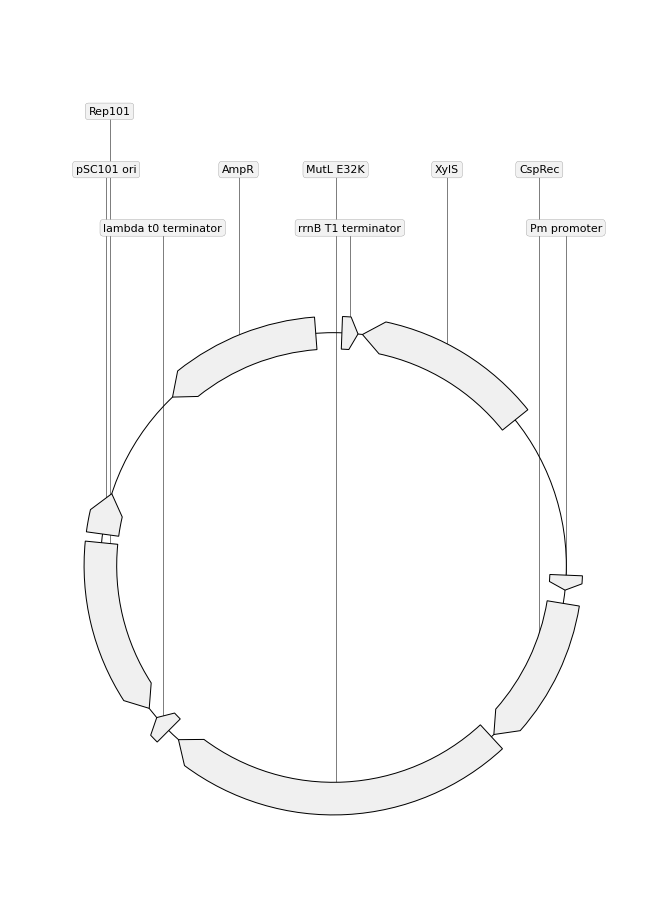

In [14]:
cl.show_map('pAV203')

To show the sequence in a particular spot, use the `zoom` method. The second argument is a couple of coordinates you want to zoom in.

Optionally, the highlight option allows to highlight a region.

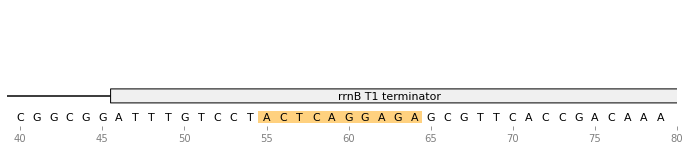

In [15]:
cl.show_sequence('pAV203', (40,80), highlight=(55,65))

### Find existing annealing oligos
To find which primers anneal to a sequence and where, use the `find_primers` method. The script will look in the `oligos` dict for matching primers, but you can override this with the `oligo` argument. The sequence can be zoomed on by giving a couple of coordinates as the optional `zoom` argument.

Primers that prime from left to right on the map are shown in green, primers that prime from right to left are shown in red.

Template name 7883 nt circular:
V1 anneals forward (--->) at 40
V22 anneals forward (--->) at 2018
V24 anneals forward (--->) at 3019
V26 anneals forward (--->) at 4016
V3 anneals forward (--->) at 5086
V11 anneals forward (--->) at 5088
V12 anneals reverse (<---) at 6303
V27 anneals reverse (<---) at 5082
V2 anneals reverse (<---) at 5022
V25 anneals reverse (<---) at 4082
V23 anneals reverse (<---) at 3079
V4 anneals reverse (<---) at 0

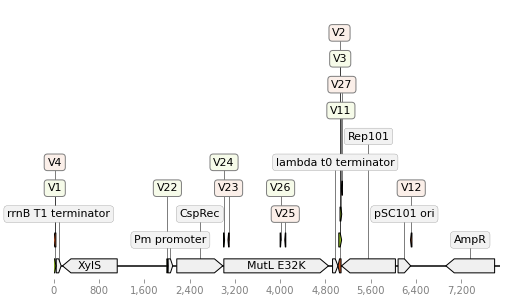

In [16]:
cl.find_primers('pAV203') 

Template name 7883 nt circular:
V1 anneals forward (--->) at 40
V22 anneals forward (--->) at 2018
V24 anneals forward (--->) at 3019
V26 anneals forward (--->) at 4016
V3 anneals forward (--->) at 5086
V11 anneals forward (--->) at 5088
V12 anneals reverse (<---) at 6303
V27 anneals reverse (<---) at 5082
V2 anneals reverse (<---) at 5022
V25 anneals reverse (<---) at 4082
V23 anneals reverse (<---) at 3079
V4 anneals reverse (<---) at 0

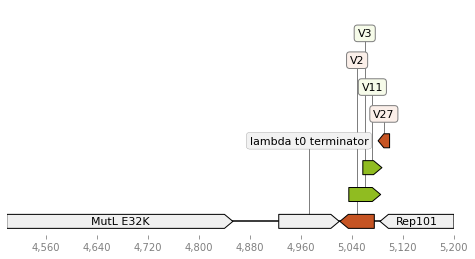

In [17]:
cl.find_primers('pAV203', zoom=(4500,5200))

## Design tools
First, Sequin comes with a few search tools.

### Find a feature

To find the coordinates of a particular feature you are interested in, use the `find_features` method. You can also provide a list of features, then the scripts looks for a region that encompasses all the mentioned features.
The `margins` arguments allows you to also include some nucleotides on each side of the feature.
The method returns a couple of coordinates.

FLP: [87:1359](+)


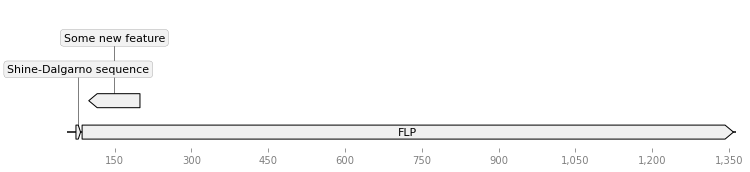

In [18]:
flp_coords = cl.find_features('pEFLP', 'FLP', margins=(30,5), plot=False)
cl.show_map('pEFLP', zoom=flp_coords)

Say you want to find the 5' UTR of a gene. You can do something like this:

FLP: [87:1359](+)


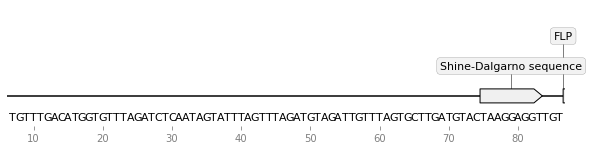

In [19]:
flp_init = cl.find_features('pEFLP', 'FLP', margins=(0,0), plot=False)[0]
flp_promoter = (flp_init-80, flp_init)
cl.show_sequence('pEFLP', flp_promoter, width=10)

### Find a DNA motif
To search for a particular DNA motif, use the `find_motif` method. Degenerate bases (like Ns) are ok. It returns a list of coordinates which are the starting points of the motif.

In [20]:
sites1 = cl.find_motif('pEFLP', 'NGGNG', +1) # Top strand
sites2 = cl.find_motif('pEFLP', 'NGGNG', -1) # Bottom strand

### Find ORFs
You can also detect all Open Reading Frames (ORF) in a strand of DNA (+1 or -1). The `min_length` argument is optional.

In [21]:
cl.find_orfs('pEFLP', 1, min_length=500)

/home/hal/.local/lib/python3.9/site-packages/Bio/Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


[(87, 1359), (216, 1359), (258, 1359), (513, 1359)]

### Design PCR primers
To design primers to amplify a region within a sequence, use the `make_primers` method. The second parameter is a couple of coordinates that delimits the region to be amplified. The target melting point can be tuned with `tm` and the minimum primer length with `limit`.

If the `names` argument is *not* specified, the method returns two primers (forward and reverse).

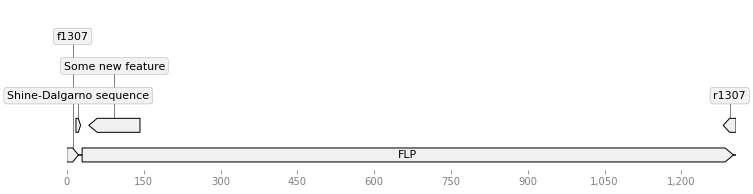

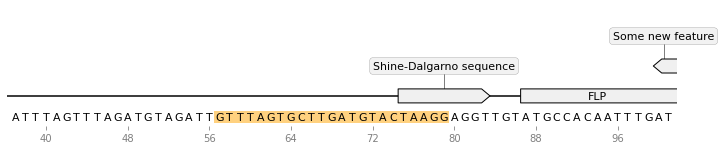

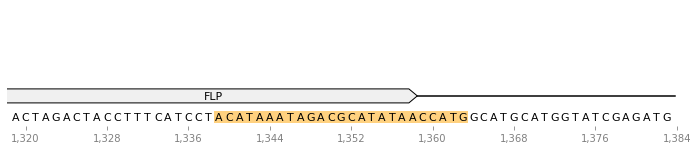

In [22]:
flp_f,flp_r = cl.make_primers('pEFLP', flp_coords, plot_annealing=True)

If `make_primers` is called with the `names` argument containing the names of the two primers, it will print them in a tab-separated format. This can be copied and pasted to your records or to a DNA ordering service. It also returns a dict containing the two oligos (so you can add it to the oligo dict with `update`).

Set to True the `plot` argument to show a map of the amplified region. If `plot_annealing` is True, the region surrounding primer annealing sequences will be displayed.

In [23]:
# Primers to sequence the insert
cl.make_primers('pAV203', (2000,3100), names=('V21','V22'), plot=False)
cl.make_primers('pAV203', (3000,4100), names=('V23','V24'), plot=False)
cl.make_primers('pAV203', (4000,5100), names=('V25','V26'), plot=False)

V21	AGTGTCCGGTTTGATAGG
V22	TCACTAGTTCTTTGACTACCG
V23	ATACACATGCCAATTCAGG
V24	TCTGCAAAGTGATTGCGC
V25	AGCAACTGGAAACGCCGC
V26	TACGGAAGGATCTGAGGTTCTTATGG


{'V25': Seq('AGCAACTGGAAACGCCGC'), 'V26': Seq('TACGGAAGGATCTGAGGTTCTTATGG')}

### Design oligos for homologous assembly
This is done by joining PCR primers together using the `make_junction` method. Say you want to make junction between PCR fragments A and B, in that order. As arguments, put 1) the reverse primer used to amplify A and 2) the forward primer used to amplify B.

This returns two oligos, that correspond to the two oligos provided as arguments with added homology tails. The length of the homology region can be changed with the `homology` argument.

In [24]:
flp_f,flp_r = cl.make_primers('pEFLP', (100,500), plot=False)
pit5_f,pit5_r = cl.make_primers('pORTMAGE', (2000,2500), plot=False)
cl.make_junction(flp_r, pit5_f)

Junction:
5' aagaagcagataagggaaatagCTTCATGCGCTCGGCATA 3'
3' TTCTTCGTCTATTCCCTTTATCgaagtacgcgagccgtat 5'


(Seq('aagaagcagataagggaaatagCTTCATGCGCTCGGCATA'),
 Seq('tatgccgagcgcatgaagCTATTTCCCTTATCTGCTTCTT'))

It's also possible to introduce a linker between the two fragments to be assembled. Just specify the sequence of the "top" strand of the linker.

In [25]:
cl.make_junction(flp_r, pit5_f, linker='AAAGGGCCCTTT')

Junction:
5'       cagataagggaaatagaaagggccctttCTTCATGCGCTCGGCATA 3'
3' TTCTTCGTCTATTCCCTTTATCtttcccgggaaagaagtacgcgag       5'


(Seq('cagataagggaaatagaaagggccctttCTTCATGCGCTCGGCATA'),
 Seq('gagcgcatgaagaaagggccctttCTATTTCCCTTATCTGCTTCTT'))

### Assign new names to new oligos
To find the latest (not used yet) oligo name, use the `latest` method with the prefix of your choice.

The `new_oligos` method takes a list/tuple of oligos and a prefix as input, and adds the oligos to the main oligo dict with adequate numbering. If a sequence is already in the dict, it will be skipped.

Then, the new oligos are printed in a copy-pastable format.

In [26]:
cl.new_oligos(cl.make_primers('pAV203', (4000,5100), plot=False), prefix='V')

V79	AGCAACTGGAAACGCCGC
V80	TACGGAAGGATCTGAGGTTCTTATGG


{'V79': Seq('AGCAACTGGAAACGCCGC'), 'V80': Seq('TACGGAAGGATCTGAGGTTCTTATGG')}